In [1]:
# Import libraries
import os
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-26 12:49:28.867136: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 12:49:28.868952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 12:49:28.894225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:49:28.894260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:49:28.894275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'mosquitoes-dataset')
test_dir = os.path.join(root_dir, 'test-dataset')

In [3]:
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
# Load data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               seed=42,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               batch_size=32,
                                                               image_size=IMG_SIZE,
                                                               )

Found 1201 files belonging to 2 classes.
Using 961 files for training.
Using 240 files for validation.


In [6]:
class_names = train_ds.class_names
class_num = len(class_names)

In [7]:
# Data augmentation
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                    tf.keras.layers.RandomRotation(0.2),
                                    ])

In [8]:
# Image normalization
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               )

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_num, activation='softmax')

In [14]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [16]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              )

In [17]:
initial_epochs = 10

In [18]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
31/31 [==============================] - 7s 160ms/step - loss: 0.8425 - accuracy: 0.5099 - val_loss: 0.7179 - val_accuracy: 0.5833
Epoch 2/10
31/31 [==============================] - 5s 143ms/step - loss: 0.7348 - accuracy: 0.5911 - val_loss: 0.6617 - val_accuracy: 0.6250
Epoch 3/10
31/31 [==============================] - 6s 181ms/step - loss: 0.6498 - accuracy: 0.6348 - val_loss: 0.6160 - val_accuracy: 0.6417
Epoch 4/10
31/31 [==============================] - 7s 187ms/step - loss: 0.6286 - accuracy: 0.6722 - val_loss: 0.5746 - val_accuracy: 0.6917
Epoch 5/10
31/31 [==============================] - 7s 184ms/step - loss: 0.6013 - accuracy: 0.6681 - val_loss: 0.5500 - val_accuracy: 0.7208
Epoch 6/10
31/31 [==============================] - 7s 185ms/step - loss: 0.5453 - accuracy: 0.7097 - val_loss: 0.5307 - val_accuracy: 0.7333
Epoch 7/10
31/31 [==============================] - 7s 197ms/step - loss: 0.5148 - accuracy: 0.7482 - val_loss: 0.5072 - val_accuracy: 0.7542
Epoch 

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

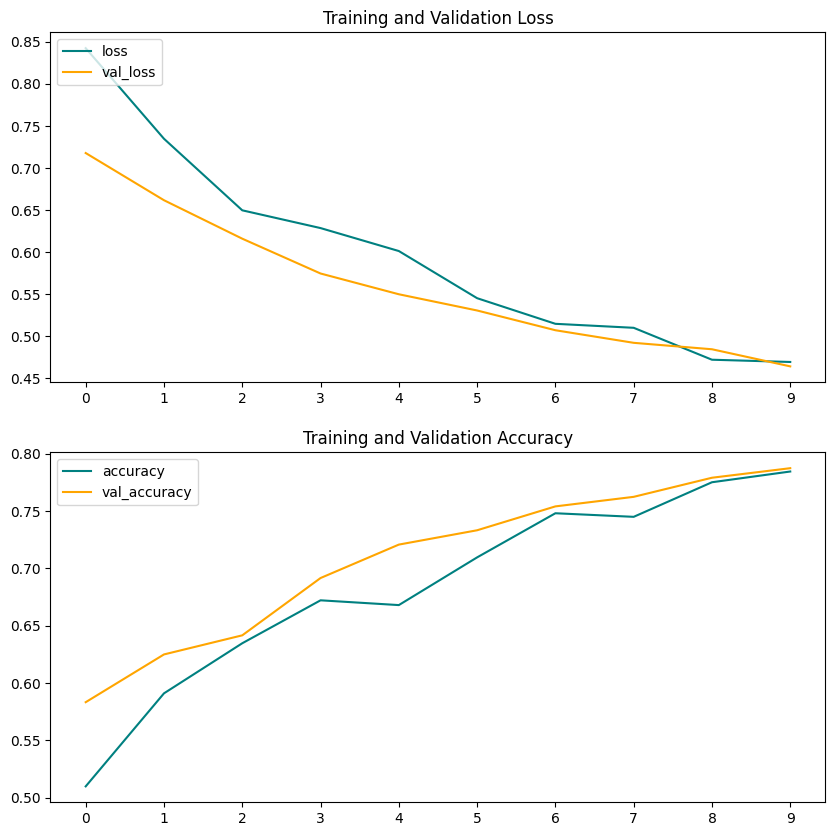

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

In [21]:
base_model.trainable = True
fine_tune_layers = 120

In [22]:
for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False

In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=base_learning_rate/10),
              metrics=['accuracy'],
              )

In [24]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds,
                         )

Epoch 11/20
31/31 [==============================] - 11s 233ms/step - loss: 0.3891 - accuracy: 0.8314 - val_loss: 0.3634 - val_accuracy: 0.8167
Epoch 12/20
31/31 [==============================] - 8s 219ms/step - loss: 0.3001 - accuracy: 0.8658 - val_loss: 0.3195 - val_accuracy: 0.8458
Epoch 13/20
31/31 [==============================] - 8s 211ms/step - loss: 0.2842 - accuracy: 0.8730 - val_loss: 0.2928 - val_accuracy: 0.8708
Epoch 14/20
31/31 [==============================] - 8s 217ms/step - loss: 0.2424 - accuracy: 0.8980 - val_loss: 0.2581 - val_accuracy: 0.8667
Epoch 15/20
31/31 [==============================] - 7s 207ms/step - loss: 0.2515 - accuracy: 0.8991 - val_loss: 0.2449 - val_accuracy: 0.8875
Epoch 16/20
31/31 [==============================] - 7s 204ms/step - loss: 0.2203 - accuracy: 0.9043 - val_loss: 0.2307 - val_accuracy: 0.8958
Epoch 17/20
31/31 [==============================] - 7s 207ms/step - loss: 0.1911 - accuracy: 0.9220 - val_loss: 0.2481 - val_accuracy: 0.895

In [25]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

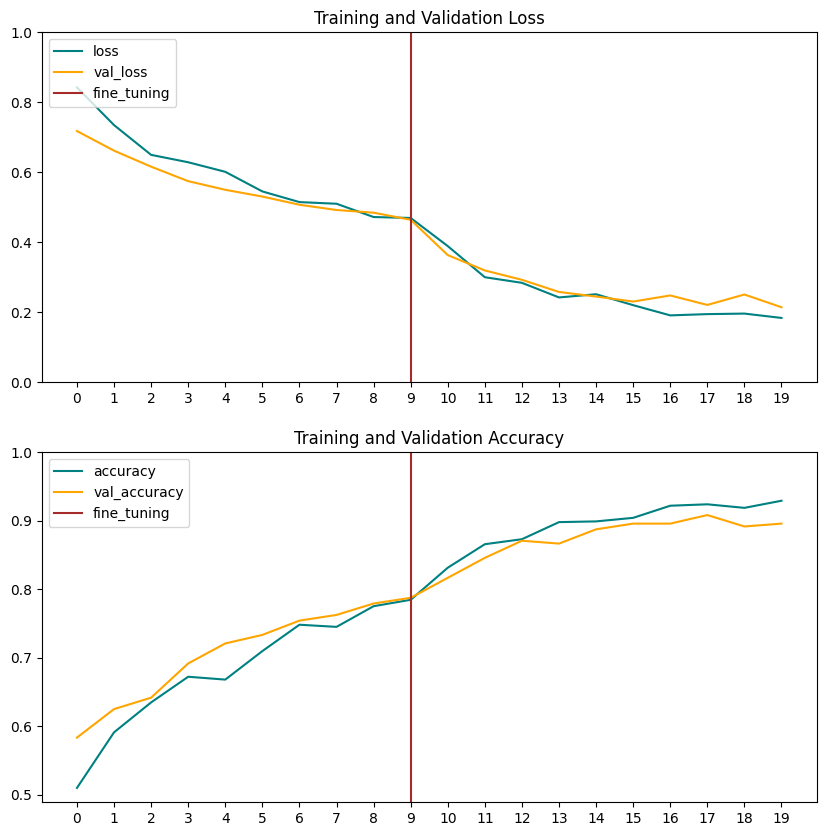

In [26]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

1/1 [==============================] - 0s 18ms/step


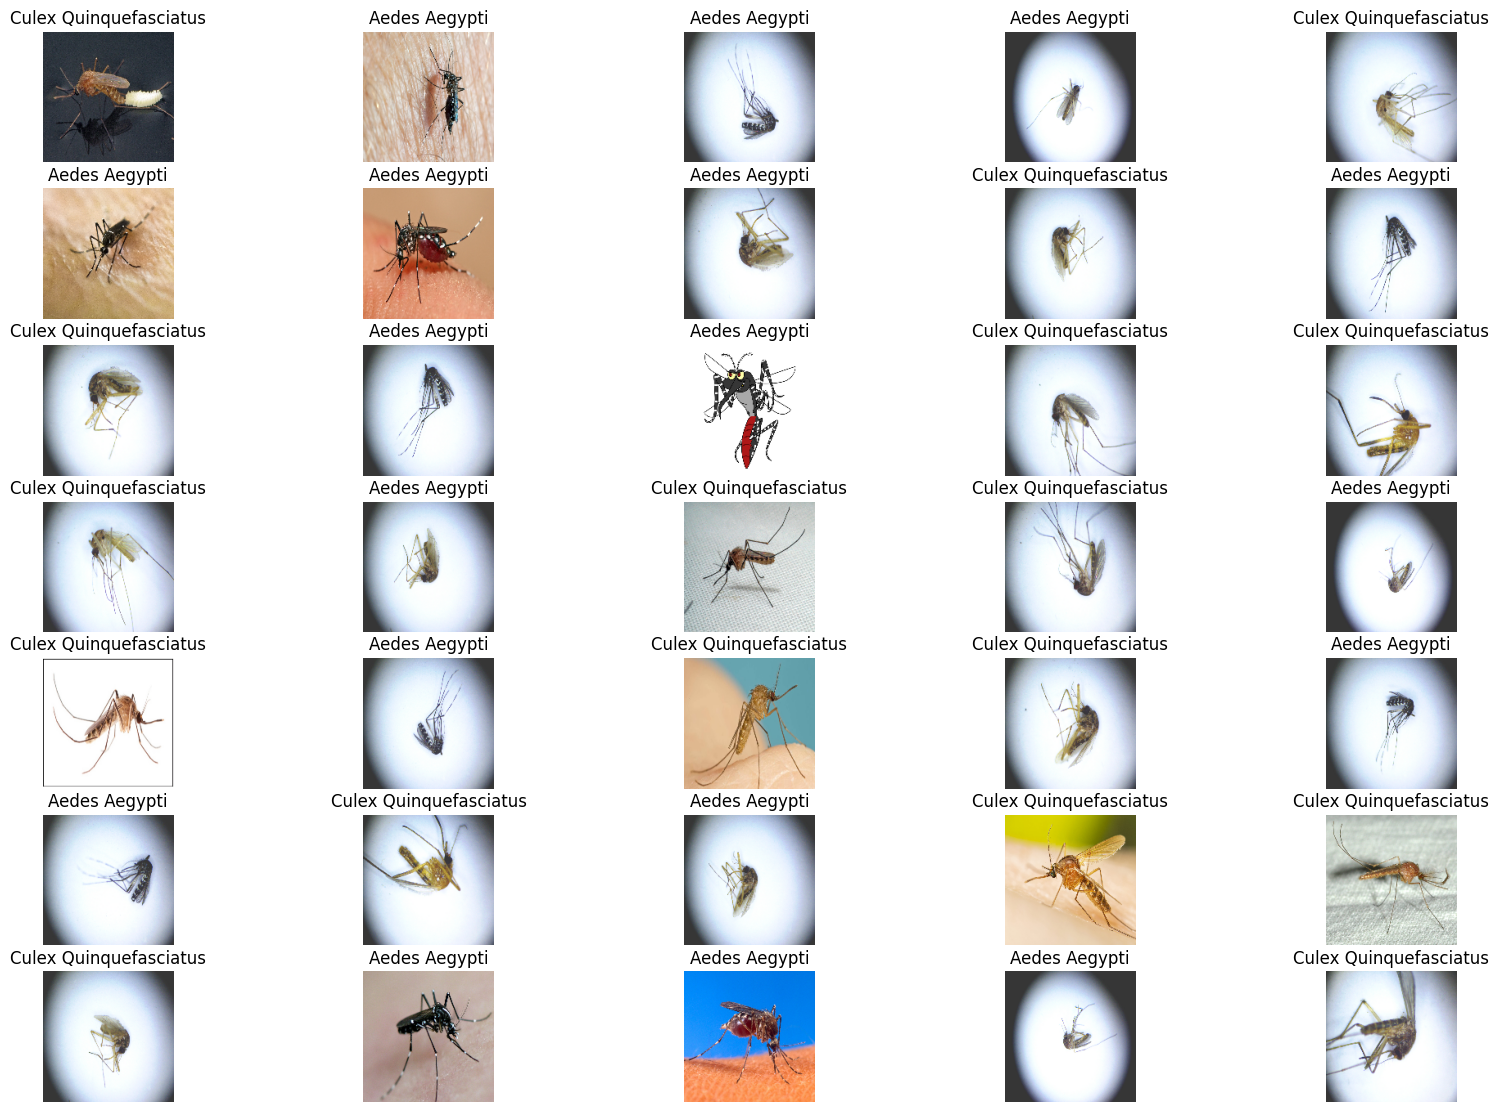

In [27]:
plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    yhat = tf.nn.softmax(yhat[0])
    yhat = np.array(yhat)

    plt.subplot(10, 5, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[np.argmax(yhat)])
    plt.axis('off')

In [28]:
model.save(os.path.join(root_dir, 'models',
           'seeded_model.keras'))